# Spotify listening data analysis

In [5]:
import pandas
import json
import matplotlib.pyplot as plt
import requests
import numpy as np
import spotipy.util as util
import time
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [28]:
from dotenv import load_dotenv
load_dotenv('/Users/ds-ingrid/vs_code.env')

'devadmin'

## Exploratory Data Analysis

### Retrieving listening history
Navigate to: Spotify website > Profile > Account > Privacy settings > Download your data. 

The data is then made available via a zip file containing a series of JSONs.

### Data overview
In my case, the folder contains 7 streaming history files. For each record, the song, artist, listening duration, and end time are specified. Each JSON file contains up to 10,000 records (songs and podcast episodes alike).

For example: 

In [335]:
# Sample record
spotifyPath = '/Users/ds-ingrid/Downloads/MyData/'
listeningHist0 = open(spotifyPath + 'StreamingHistory0.json')
listeningHist0 = json.load(listeningHist0)
listeningHist0[0]

{'endTime': '2020-09-06 12:01',
 'artistName': 'Justice',
 'trackName': 'D.A.N.C.E. - MSTRKRFT Remix',
 'msPlayed': 1642}

In [336]:
# Loading data from all 7 JSON files
listeningHist = []
listeningHistPaths = [f'/Users/ds-ingrid/Downloads/MyData/StreamingHistory{i}.json' for i in range(0, 7)]

for file in listeningHistPaths:
    tempHist = json.load(open(file))
    listeningHist = listeningHist + tempHist

# Convert to dataframe
listeningHist = pandas.DataFrame(listeningHist)

len(listeningHist)

65243

There are a total of 65K records, from September 2020 to early November 2021. Not quite sure why this isn't my full listening history since 2016. 

Ideally, this will later be augmented with additional info on each song/artist (e.g. genre, in Liked Songs, in playlist), but for the time being I'll work only with the 4 fields provided by default. 

Some summary stats: 
* 5,061 unique songs
* 1,630 unique artists
* 1,417 hours of total listening time

In [337]:
# Unique songs
len(set(listeningHist['artistName']))

# Unique artists
len(set(listeningHist['artistName']))

# Total listening time
sum(listeningHist['msPlayed'])/(1000*60*60)


1417.0906655555555

### EDA visualizations

* Songs by listening time
* Artists by listening time
* Artists by number of songs listened to

Text(0.5, 1.0, 'Most listened songs')

<Figure size 432x288 with 0 Axes>

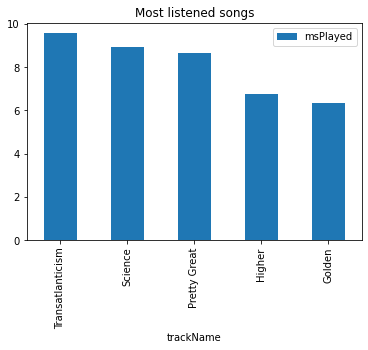

In [133]:
# Songs by total listening time
trackAgg = listeningHist.groupby(['trackName'])['msPlayed'].sum()
trackAgg = pandas.DataFrame(trackAgg)
trackAgg['msPlayed'] = trackAgg['msPlayed']/(1000*60*60)
trackAggTop5 = trackAgg.sort_values(by='msPlayed',ascending=False)[0:5]

plt.figure()
trackAggTop5.plot(kind="bar").set_title("Most listened songs")

Text(0.5, 1.0, 'Most listened artists')

<Figure size 432x288 with 0 Axes>

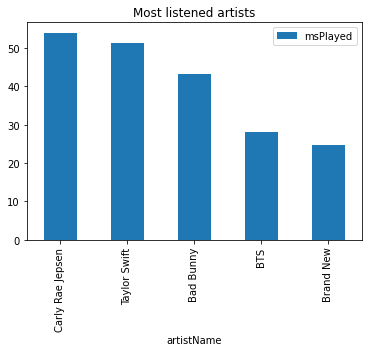

In [338]:
# Artists by total listening time
artistAgg = listeningHist.groupby(['artistName'])['msPlayed'].sum()
artistAgg = pandas.DataFrame(artistAgg)
artistAgg['msPlayed'] = artistAgg['msPlayed']/(1000*60*60)
artistAggTop5 = artistAgg.sort_values(by='msPlayed',ascending=False)[0:5]

plt.figure()
artistAggTop5.plot(kind="bar").set_title("Most listened artists")

<Figure size 432x288 with 0 Axes>

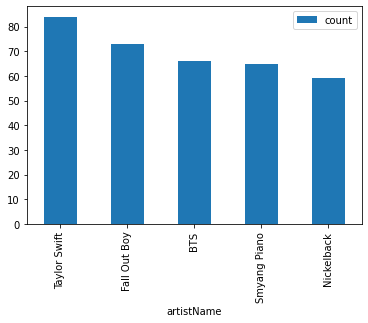

In [135]:
# Artists by number of songs listened to listening time (min 60 seconds of listening time)
artistSongCombo = listeningHist[listeningHist['msPlayed']>=60000].reset_index(drop=True)
artistSongCombo = artistSongCombo[['artistName','trackName']].drop_duplicates().reset_index(drop=True)
artistSongCombo = artistSongCombo.groupby(['artistName'])['trackName'].count().reset_index(name="count")
artistSongCombo = artistSongCombo.sort_values(by='count',ascending=False)
artistSongComboTop5 = artistSongCombo[0:5]#.reset_index(drop=True)

plt.figure()
artistSongComboTop5.plot.bar(x='artistName')

## Spotify API data 
Unfortunately, Spotify doesn't provide much additional information about the songs listened to, especially in terms of features (e.g. genre, BPM, key, speechiness). All of these however are available via the Spofity API. More specifically the [audio features](https://developer.spotify.com/documentation/web-api/reference/#/operations/get-audio-features) and [audio analysis](https://developer.spotify.com/documentation/web-api/reference/#/operations/get-audio-analysis) endpoints. 

For example, the features for the song Science by Allie X are as follows: 

In [1]:
# Authenticate
username = 'nope_12345'
client_id = os.environ['SPOTIFY_CLIENT_ID']
client_secret = os.environ['SPOTIFY_CLIENT_SECRET']
redirect_uri = 'http://localhost:8888/callback'
scope = 'user-read-recently-played'

token = util.prompt_for_user_token(username=username, 
                                   scope=scope, 
                                   client_id=client_id,   
                                   client_secret=client_secret,     
                                   redirect_uri=redirect_uri)

NameError: name 'util' is not defined

In [540]:
# Retrive song ID (code borrowed from https://towardsdatascience.com/get-your-spotify-streaming-history-with-python-d5a208bbcbd3)
headers = {
    'Accept': 'application/json',
    'Content-Type': 'application/json',
    'Authorization': f'Bearer ' + token,
    }

params = [('q', 'Science Allie X'),
    ('type', 'track')]

response = requests.get('https://api.spotify.com/v1/search', 
                    headers = headers, params = params, timeout = 5)

json = response.json()
first_result = json['tracks']['items'][0]
track_id = first_result['id']

# Retrieve song features
response = requests.get(f'https://api.spotify.com/v1/audio-features/{track_id}', 
                    headers = headers, params = params, timeout = 5)
response.json()

{'danceability': 0.575,
 'energy': 0.81,
 'key': 6,
 'loudness': -4.381,
 'mode': 0,
 'speechiness': 0.0381,
 'acousticness': 0.00173,
 'instrumentalness': 1.12e-06,
 'liveness': 0.203,
 'valence': 0.5,
 'tempo': 159.953,
 'type': 'audio_features',
 'id': '6OteeaJa1FSjBA6o1Ixwfq',
 'uri': 'spotify:track:6OteeaJa1FSjBA6o1Ixwfq',
 'track_href': 'https://api.spotify.com/v1/tracks/6OteeaJa1FSjBA6o1Ixwfq',
 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/6OteeaJa1FSjBA6o1Ixwfq',
 'duration_ms': 235880,
 'time_signature': 4}

In [397]:
# Retrieve song analysis (1st section only)
response = requests.get(f'https://api.spotify.com/v1/audio-analysis/{track_id}', 
                    headers = headers, params = params, timeout = 5)
json = response.json()

json['sections'][0]


{'start': 0.0,
 'duration': 9.4479,
 'confidence': 1.0,
 'loudness': -15.278,
 'tempo': 159.835,
 'tempo_confidence': 0.326,
 'key': 6,
 'key_confidence': 0.388,
 'mode': 0,
 'mode_confidence': 0.613,
 'time_signature': 4,
 'time_signature_confidence': 1.0}

## Building a scoring/recommender system

### Objective
* As a user, I would like to be able to provide my profile ID and the URL of a playlist or album, and have it generate a score for each song reflecting how likely I am to enjoy it.
    * Either rank all songs, or provide the top X only
* A model would be trained based on my listening history, with each listened song first being assigned a score based on the total listening time or total number of 75%+ plays. This could then maybe be re-worked into either a classification (e.g. top quintile vs bottom quintile vs rest) or regression problem (score out of 10 or 100). 

### Data collection and cleaning
To try to limit the number of API calls required, only songs that were listened to for at least 10 seconds will be included. 

A few helper functions were first defined to retrieve and process the song features data from the API:

In [541]:
def retrieve_track_id(token,track,artist):
    # Define header
    headers = {
    'Accept': 'application/json',
    'Content-Type': 'application/json',
    'Authorization': f'Bearer ' + token,
    }

    # Define request
    params = [('q', f'{track} {artist}'),
    ('type', 'track')]

    # Make request
    response = requests.get('https://api.spotify.com/v1/search', 
                    headers = headers, params = params, timeout = 5)

    # Process output (first returned result only)
    try:
        json = response.json()
        first_result = json['tracks']['items'][0]
        track_id = first_result['id']
    except:
        track_id = None

    return track_id

def retrieve_track_features(token,track_id):
    #Define header
    headers = {
    'Accept': 'application/json',
    'Content-Type': 'application/json',
    'Authorization': f'Bearer ' + token,
    }

    # Define request
    params = [('q', f'{id} '),
    ('type', 'track')]

    # Make request
    response = requests.get(f'https://api.spotify.com/v1/audio-features/{track_id}', 
                    headers = headers, params = params, timeout = 5)
    features = response.json()

    return features

def retrieve_track_analysis(token,track_id):
    #Define header
    headers = {
    'Accept': 'application/json',
    'Content-Type': 'application/json',
    'Authorization': f'Bearer ' + token,
    }

    # Define request
    params = [('q', f'{id} '),
    ('type', 'track')]

    # Make request
    response = requests.get(f'https://api.spotify.com/v1/audio-analysis/{track_id}', 
                    headers = headers, params = params, timeout = 5)
    analysis = response.json().get('sections')

    return analysis


The track feature data was then retrieved for all unique tracks. 

In [542]:
# Limit to track with a minimum of 10 sec of total listening history
listeningHistAgg = listeningHist.groupby(['artistName', 'trackName'])['msPlayed'].sum().reset_index(name="msPlayed").reset_index()
listeningHistAgg = listeningHistAgg[listeningHistAgg['msPlayed']>=(10*1000)].reset_index(drop=True)
listeningHistAgg['secPlayed'] = listeningHistAgg['msPlayed']/1000
listeningHistAgg['mnPlayed'] = listeningHistAgg['secPlayed']/60

# Get list of unique tracks
unique_tracks = listeningHistAgg[['artistName', 'trackName']].drop_duplicates().reset_index(drop=True)

# Retrieve data for all tracks
track_features_data = []
track_analysis_data = []
for idx in range(0,len(unique_tracks)):
    temp_track_id = retrieve_track_id(token,track=unique_tracks['trackName'][idx],artist=unique_tracks['artistName'][idx])
    
    if temp_track_id is not None:
        temp_track_data = retrieve_track_features(token,track_id=temp_track_id)
        temp_track_data['artist_name'] = unique_tracks['artistName'][idx]
        temp_track_data['track_name'] = unique_tracks['trackName'][idx]
        track_features_data.append(temp_track_data)

        temp_track_data = retrieve_track_analysis(token,track_id=temp_track_id)
        if temp_track_data is not None:
            for element in temp_track_data:
                element['artist_name'] = unique_tracks['artistName'][idx]
                element['track_name'] = unique_tracks['trackName'][idx]
            track_analysis_data.append(temp_track_data)

In [494]:
# Save to CSVs for future use
track_features_data = pandas.DataFrame(track_features_data)
track_features_data.to_csv('/Users/ds-ingrid/GitHub/spotify-scorer/raw_feature_data.csv')

track_analysis_data_flat = [item for sublist in track_analysis_data for item in sublist]
track_analysis_data_flat = pandas.DataFrame(track_analysis_data_flat).reset_index(drop=True)
track_analysis_data_flat.to_csv('/Users/ds-ingrid/GitHub/spotify-scorer/raw_analysis_data.csv')

### Feature engineering

In addition to the features returned directly by the API endpoint, a few other features were created: 
* Binary variables indicating whether the artist appears in my top 5, top 20, top 50, and top 100 based on total listening time
* Average and range values based on the songs' different sections
* The song popularity, provided from the track endpoint as a value from 0 to 100 (not implemented yet)

In [506]:
# Read in data
track_data = pandas.read_csv('/Users/ds-ingrid/GitHub/spotify-scorer/raw_feature_data.csv')

# Create artist ranking
artist_ranking = listeningHistAgg.groupby(['artistName'])['mnPlayed'].agg('sum').reset_index()
artist_ranking = artist_ranking.sort_values(by='mnPlayed',ascending=False).reset_index(drop=True)
artist_ranking['artist_rank'] = artist_ranking.index + 1

artist_ranking['is_top5_artist'] = np.where(artist_ranking['artist_rank']<=5,1,0)
artist_ranking['is_top20_artist'] = np.where(artist_ranking['artist_rank']<=20,1,0)
artist_ranking['is_top50_artist'] = np.where(artist_ranking['artist_rank']<=50,1,0)
artist_ranking['is_top100_artist'] = np.where(artist_ranking['artist_rank']<=100,1,0)
artist_ranking = artist_ranking[['artistName','is_top5_artist','is_top20_artist','is_top50_artist','is_top100_artist']]

# Join back to main dataframe
track_data = track_data.merge(artist_ranking,how='inner',left_on='artist_name',right_on='artistName')


In [508]:
# Section data aggregates
## Read in from CSV
track_analysis_df = pandas.read_csv('/Users/ds-ingrid/GitHub/spotify-scorer/raw_analysis_data.csv')

## Add row number by track name
track_analysis_df = track_analysis_df.sort_values(by=['track_name','artist_name','start']).reset_index(drop=True)
track_analysis_df['section_id'] = track_analysis_df.groupby(['track_name','artist_name']).cumcount()+1;

## Aggregates and summary values
track_analysis_df['num_sections'] = track_analysis_df.groupby(['track_name','artist_name'])['section_id'].transform('count')
track_analysis_df['avg_section_duration'] = track_analysis_df.groupby(['track_name','artist_name'])['duration'].transform('mean')
track_analysis_df['stdev_section_duration'] = track_analysis_df.groupby(['track_name','artist_name'])['duration'].transform('std')

track_analysis_df['tempo_range'] =  track_analysis_df.groupby(['track_name','artist_name'])['tempo'].transform('max') - track_analysis_df.groupby(['track_name','artist_name'])['tempo'].transform('min')
track_analysis_df['key_range'] =  track_analysis_df.groupby(['track_name','artist_name'])['key'].transform('max') - track_analysis_df.groupby(['track_name','artist_name'])['key'].transform('min')
track_analysis_df['loudness_range'] =  track_analysis_df.groupby(['track_name','artist_name'])['loudness'].transform('max') - track_analysis_df.groupby(['track_name','artist_name'])['loudness'].transform('min')

track_analysis_df['tempo_stdev'] =  track_analysis_df.groupby(['track_name','artist_name'])['tempo'].transform('std')
track_analysis_df['key_stdev'] =  track_analysis_df.groupby(['track_name','artist_name'])['key'].transform('std')
track_analysis_df['loudness_stdev'] =  track_analysis_df.groupby(['track_name','artist_name'])['loudness'].transform('std')

track_analysis_df['key_max'] = track_analysis_df.groupby(['track_name','artist_name'])['key'].transform('max')
track_analysis_df['key_min'] = track_analysis_df.groupby(['track_name','artist_name'])['key'].transform('min')

## First section details
track_analysis_df['first_section_tempo'] = np.where(track_analysis_df['section_id']==1,track_analysis_df['tempo'],-1000)
track_analysis_df['first_section_key'] = np.where(track_analysis_df['section_id']==1,track_analysis_df['key'],-1000)
track_analysis_df['first_section_loudness'] = np.where(track_analysis_df['section_id']==1,track_analysis_df['loudness'],-1000)

## Second section details
track_analysis_df['second_section_tempo'] = np.where(track_analysis_df['section_id']==2,track_analysis_df['tempo'],-1000)
track_analysis_df['second_section_key'] = np.where(track_analysis_df['section_id']==2,track_analysis_df['key'],-1000)
track_analysis_df['second_section_loudness'] = np.where(track_analysis_df['section_id']==2,track_analysis_df['loudness'],-1000)

## Third section details
track_analysis_df['third_section_tempo'] = np.where(track_analysis_df['section_id']==3,track_analysis_df['tempo'],-1000)
track_analysis_df['third_section_key'] = np.where(track_analysis_df['section_id']==3,track_analysis_df['key'],-1000)
track_analysis_df['third_section_loudness'] = np.where(track_analysis_df['section_id']==3,track_analysis_df['loudness'],-1000)

## Aggregate first-to-third section details on all rows
col_list = ['first_section_tempo','first_section_key','first_section_loudness',
            'second_section_tempo','second_section_key','second_section_loudness',
            'third_section_tempo','third_section_key','third_section_loudness']

for col in col_list:
    track_analysis_df[col] = track_analysis_df.groupby(['track_name','artist_name'])[col].transform('max')

## Remove unecessary columns
track_analysis_df = track_analysis_df[['artist_name',
       'track_name', 'num_sections', 'avg_section_duration',
       'stdev_section_duration', 'tempo_range', 'key_range', 'loudness_range',
       'tempo_stdev', 'key_stdev', 'loudness_stdev', 'key_max', 'key_min',
       'first_section_tempo', 'first_section_key', 'first_section_loudness',
       'second_section_tempo', 'second_section_key', 'second_section_loudness',
       'third_section_tempo', 'third_section_key', 'third_section_loudness']]

track_analysis_df = track_analysis_df.drop_duplicates().reset_index(drop=True)

# Join back to main dataframe
track_data = track_data.merge(track_analysis_df,how='inner',
                            left_on=['artist_name','track_name'],
                            right_on=['artist_name','track_name'])


### Dependent variable

The dependent variable here will be based on the total amount of time spent listening to each song. Each song is assigned a category from 1 to 5, with 1 being the songs in the first quintile based on listening time (i.e. least listened to), 2 in the 2nd lowest quintile, and so on. 

In [509]:
# Join features retrieved from API to listening history aggregated data
track_data_df = pandas.DataFrame(track_data)
track_data_df = listeningHistAgg.merge(track_data_df,how='inner',left_on=['artistName', 'trackName'],right_on=['artist_name', 'track_name']) #TODO: change to left and see how many track have no data

# Create depvar based on quintiles
track_data_df['depvar'] = pandas.qcut(track_data_df['mnPlayed'], 3, labels=False)+1

# QA checks
#(listeningHistFeatures['mnPlayed']).quantile([0,0.2,0.4,0.6,0.8])
#listeningHistFeatures[listeningHistFeatures['depvar']==5]['track_name']

### Pre-processing

All numerical variables are scaled and normalized, with any missing values replaced by the mean. For all categorical variables, imputing is done using the most frequent value instead. 

In [537]:
# Identify numeric vs categorical columns
numeric_cols = ['danceability','energy','loudness','speechiness','acousticness','instrumentalness','liveness','valence','tempo','num_sections', 'avg_section_duration','stdev_section_duration', 'tempo_range', 'key_range', 'loudness_range',
'tempo_stdev', 'key_stdev', 'loudness_stdev', 'key_max', 'key_min','first_section_tempo', 'first_section_key', 'first_section_loudness',
'second_section_tempo', 'second_section_key', 'second_section_loudness','third_section_tempo', 'third_section_key', 'third_section_loudness']
categorical_cols = ['key','mode','is_top5_artist','is_top20_artist','is_top50_artist','is_top100_artist']

# Define pre-processing pipelines
numeric_transformer = Pipeline(
    steps=[("imputer",SimpleImputer(strategy="median")),("scaler",StandardScaler())]
)

categorical_transformer = Pipeline(
    steps=[("imputer",SimpleImputer(strategy="most_frequent"))]
)

# Define final preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
        ])

# Split training, validation, and testing
track_data_df = track_data_df[track_data_df['key'].notnull()].reset_index(drop=True)
X = track_data_df[['danceability','energy','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo',
'key','is_top5_artist','is_top20_artist','is_top50_artist','is_top100_artist','num_sections', 'avg_section_duration','stdev_section_duration', 'tempo_range', 'key_range', 'loudness_range',
'tempo_stdev', 'key_stdev', 'loudness_stdev', 'key_max', 'key_min','first_section_tempo', 'first_section_key', 'first_section_loudness',
'second_section_tempo', 'second_section_key', 'second_section_loudness','third_section_tempo', 'third_section_key', 'third_section_loudness']]
y = track_data_df['depvar']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.25,random_state=0)

# Pre-process training, validation, and test sets
scaler = preprocessor.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

### Model training (XGboost)

In [1]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Train model
xgb_model = XGBClassifier(objective="multi:softprob", random_state=0, learning_rate = 0.05,
                max_depth = 10, alpha = 10, n_estimators = 20)
xgb_model.fit(X_train, y_train)

# Make predictions on test data
y_pred = xgb_model.predict(X_test)
accuracy_pred = accuracy_score(y_test,y_pred)
print(f"Model accuracy is: {round(accuracy_pred*100,0)}%")

# evaluate predictions
#accuracy = accuracy_score(y_test, predictions)

ModuleNotFoundError: No module named 'xgboost'

In [524]:
from sklearn.neighbors import KNeighborsClassifier


knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
accuracy_pred = accuracy_score(y_test,y_pred)
print(f"Model accuracy is: {round(accuracy_pred*100,0)}%")

Model accuracy is: 42.0%


In [536]:
X_train

,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,...,key_min,first_section_tempo,first_section_key,first_section_loudness,second_section_tempo,second_section_key,second_section_loudness,third_section_tempo,third_section_key,third_section_loudness
247,0.442,0.375,-9.832,0.0,0.0632,0.4900,0.000000,0.1060,0.0723,141.931,...,0,143.980,0,-34.916,139.994,4,-13.522,141.513,7,-9.294
7,0.837,0.636,-7.643,1.0,0.0860,0.0395,0.001250,0.3420,0.2740,145.972,...,0,145.290,5,-13.609,145.989,1,-6.711,145.848,10,-7.132
360,0.724,0.793,-3.982,1.0,0.0895,0.0597,0.000000,0.2010,0.8170,98.003,...,1,98.032,10,-9.994,97.813,10,-3.294,98.356,10,-4.234
383,0.486,0.871,-4.475,0.0,0.3370,0.0278,0.000000,0.3130,0.6590,85.411,...,0,85.707,7,-7.458,83.804,5,-4.433,86.809,9,-6.163
22,0.641,0.877,-2.726,0.0,0.0337,0.0140,0.000131,0.0792,0.4540,130.045,...,3,129.754,3,-8.258,130.266,3,-6.986,129.939,3,-2.867
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,0.786,0.852,-2.687,1.0,0.0813,0.0687,0.000000,0.0759,0.4550,125.036,...,1,124.592,1,-26.689,125.071,10,-3.318,125.054,8,-2.125
192,0.335,0.151,-17.639,1.0,0.0465,0.8470,0.044400,0.1950,0.1610,85.136,...,0,85.678,5,-13.792,89.655,5,-17.125,86.410,5,-16.930
117,0.523,0.564,-6.481,0.0,0.0276,0.3880,0.001580,0.3440,0.1350,119.965,...,2,118.515,2,-26.654,119.957,2,-13.978,119.920,11,-10.186
47,0.549,0.374,-12.049,1.0,0.0244,0.6000,0.000000,0.1780,0.4390,104.311,...,5,106.598,10,-15.704,105.071,10,-15.996,104.312,5,-13.432


In [364]:
#track_data_df.groupby(['depvar'])['valence'].agg('mean')
# Songs in the highest quintile tend to haveL higher energy, lower acounsticness, be louder, and be more danceable

track_data_df[track_data_df['depvar']==1][['trackName','mnPlayed']]

,trackName,mnPlayed
1,HWAA,0.391617
4,Oh my god - English Version,0.430400
5,Uh-Oh,1.266117
12,Ugly,0.290150
21,I My Me Mine (Japanese Ver.),0.298183
...,...,...
3619,La Llorona,2.630900
3620,Week-end à Rome,2.550017
3621,Dragonfly,2.473467
3622,In Depth,2.556883
